# Age Detection Dataset

Predict the age of an Actor or Actress from facial attributes

Source: [Kaggle](https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset?select=train.csv)

---

## About Dataset

### Context

Recently, many applications from biometrics,to entertainment use the information extracted from face images that contain information about age, gender, ethnic background, and emotional state. Automatic age estimation from facial images is one of the popular and challenging tasks that have different fields of applications such as controlling the content of the watched media depending on the customer's age.
So facial feature analysis has been a topic of interest mainly due to its applicability and Deep Learning techniques are now making it possible for face analysis to be not just a dream but a reality. This simple practice dataset can get you more acquainted with application of deep learning in age detection.

### Content

Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications.

The dataset provided a total of 19906 images.The attributes of data are as follows:

* ID – Unique ID of image
* Class – Age bin of person in image

---

## 1. Import Libraries

In [116]:
# Import libraries

import numpy as np
import pandas as pd
import os

import tensorflow as tf
from keras import layers, models
import cv2 # To read photos
import pickle # To save the data
from sklearn.model_selection import train_test_split # To split the data

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## 2. Read and clean data

In [2]:
# Images path
path = './data/age/'
image_path = './data/age/Train/'

In [75]:
# Read csv with image information
df = pd.read_csv(f'{path}train.csv')
df.head

<bound method NDFrame.head of               ID   Class
0        377.jpg  MIDDLE
1      17814.jpg   YOUNG
2      21283.jpg  MIDDLE
3      16496.jpg   YOUNG
4       4487.jpg  MIDDLE
...          ...     ...
19901   2482.jpg  MIDDLE
19902  20085.jpg   YOUNG
19903  19663.jpg  MIDDLE
19904  10132.jpg  MIDDLE
19905   9896.jpg  MIDDLE

[19906 rows x 2 columns]>

<AxesSubplot:>

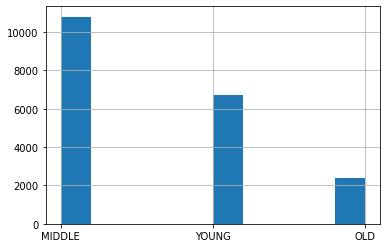

In [76]:
# Check classes
df['Class'].hist()

In [77]:
LIMIT = len(df[df['Class'] == 'OLD'])
LIMIT

2396

#### Create dummy variable for class

In [78]:
# Create numeric column for categories
# 0: Young, 1: Middle, 2: Old

classes = ['YOUNG', 'MIDDLE', 'OLD']
categories = [0, 1, 2]

df['Category'] = df['Class'].replace(classes,
                        categories, inplace=False)
df.head()

,ID,Class,Category
0,377.jpg,MIDDLE,1
1,17814.jpg,YOUNG,0
2,21283.jpg,MIDDLE,1
3,16496.jpg,YOUNG,0
4,4487.jpg,MIDDLE,1


In [79]:
# Check the ids
pd.unique(df[['Class', 'Category']].values.ravel())

array(['MIDDLE', 1, 'YOUNG', 0, 'OLD', 2], dtype=object)

(65, 48)


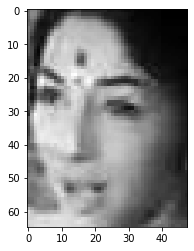

In [80]:
# Test read images
photo = cv2.imread(os.path.join(image_path, df['ID'][10]), cv2.IMREAD_GRAYSCALE)
print(photo.shape)
plt.imshow(photo, 'gray')

In [81]:
temp_resize = cv2.resize(photo,(28, 28))
type(temp_resize)

numpy.ndarray

# 3. Read photos and create dataset

In [83]:
# Read photos
def read_photo(im_path: str, IMAGE_SIZE: int):
    """
    Read photo from path and return a Numpy array of image
    :return: image_temp_resize
    """
    image_data_temp = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)                 # Read Image on gray scale
    image_temp_resize = cv2.resize(image_data_temp,(IMAGE_SIZE, IMAGE_SIZE))    # Resize photo
    return image_temp_resize

In [84]:
# Create x_data and y_data
def build_data(x_temp: list, y_temp: list, IMAGE_SIZE: int):
    X_temp = np.asanyarray(x_temp) / 255                          # Normalize data
    
    X_temp = X_temp.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    Y_temp = np.asarray(y_temp)

    return X_temp, Y_temp

In [85]:
IMAGE_SIZE = 40

In [86]:
# Read all pictures and save in variables

# Init variables to append the info
x_temp = []
y_temp = []

limit_class = [0, 0, 0]


for index, row in df.iterrows():
    try:
        if limit_class[row['Category']] >= LIMIT:
            continue

        path_image = os.path.join(image_path, row['ID'])
        image_resize = read_photo(path_image, IMAGE_SIZE)
        
        x_temp.append(image_resize)
        y_temp.append(row['Category'])

        # Filter data to get the same amount of each class
        limit_class[row['Category']] += 1
        if all(x >= LIMIT for x in limit_class):
            break
        
    except Exception as e:
        print(f"Error trying to read {row['ID']} Error {e}")
        continue

In [13]:
# ORIGINAL


# # Read all pictures and save in variables

# # Init variables to append the info
# x_temp = []
# y_temp = []


# for index, row in df.iterrows():
#     try:
#         path_image = os.path.join(image_path, row['ID'])
#         image_resize = read_photo(path_image, IMAGE_SIZE)
        
#         x_temp.append(image_resize)
#         y_temp.append(row['Category'])
        
#     except Exception as e:
#         print(f"Error trying to read {row['ID']} Error {e}")
#         continue

In [87]:
# Create final data in features and label

X_features, Y_labels = build_data(x_temp, y_temp, IMAGE_SIZE)

### 3.1. Save features and labels to reuse

In [100]:
pickle_out = open('./age_detection_data/X_features','wb')
# pickle_out = open('X_features','wb')
pickle.dump(X_features, pickle_out)
pickle_out.close()

# Write the Y Label Data
pickle_out = open('./age_detection_data/Y_labels','wb')
# pickle_out = open('Y_labels', 'wb')
pickle.dump(Y_labels, pickle_out)
pickle_out.close()

# 4. Create Model

In [101]:
# Get the X and Y data from pickle
X_Temp = open('./age_detection_data/X_features','rb')
X_data = pickle.load(X_Temp)
print(X_data.shape)

Y_Temp = open('./age_detection_data/Y_labels','rb')
Y_data = pickle.load(Y_Temp)
print(Y_data.shape)

(7188, 40, 40, 1)
(7188,)


In [102]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

#### General functions to train

In [168]:
def run_model(model, name):
        history = model.fit(
                X_train,
                y_train, 
                batch_size=32,
                validation_data=(X_test, y_test), 
                epochs=25,
                validation_split=0.3
        )
        save_model(model, name) 
        plot_accuracy(history)
        return history, model


def save_model(model, name):
    model.save(os.path.join('./age_detection_data/', name))


def plot_accuracy(history):
        plt.plot(history.history['accuracy'])
        plt.title('Age detection accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()


def test_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        y_prediction = np.argmax(y_pred, axis=1)
        
        cm = confusion_matrix(y_test, y_prediction)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()
        print(classification_report(y_test, y_prediction))

### 4.1 First Model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(150, (3, 3), input_shape=X_data.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(75, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5), # Disable some neurons to improve the CNN
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

2022-07-22 00:11:07.685718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jota/projects/ml-course/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-22 00:11:07.686116: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 00:11:07.686385: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-H0LOU2C): /proc/driver/nvidia/version does not exist


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=32,
    validation_data=(X_test, y_test), 
    epochs=20,
    validation_split=0.3
)

Epoch 1/20
498/498 [==============================] - 115s 229ms/step - loss: 0.8764 - accuracy: 0.5882 - val_loss: 0.8186 - val_accuracy: 0.6271
Epoch 2/20
498/498 [==============================] - 114s 230ms/step - loss: 0.8085 - accuracy: 0.6297 - val_loss: 0.7632 - val_accuracy: 0.6615
Epoch 3/20
498/498 [==============================] - 128s 257ms/step - loss: 0.7790 - accuracy: 0.6441 - val_loss: 0.7558 - val_accuracy: 0.6592
Epoch 4/20
498/498 [==============================] - 114s 228ms/step - loss: 0.7557 - accuracy: 0.6630 - val_loss: 0.7174 - val_accuracy: 0.6838
Epoch 5/20
498/498 [==============================] - 110s 222ms/step - loss: 0.7311 - accuracy: 0.6721 - val_loss: 0.7145 - val_accuracy: 0.6931
Epoch 6/20
498/498 [==============================] - 105s 211ms/step - loss: 0.7135 - accuracy: 0.6856 - val_loss: 0.6871 - val_accuracy: 0.6969
Epoch 7/20
498/498 [==============================] - 106s 212ms/step - loss: 0.6934 - accuracy: 0.6920 - val_loss: 0.6966 -

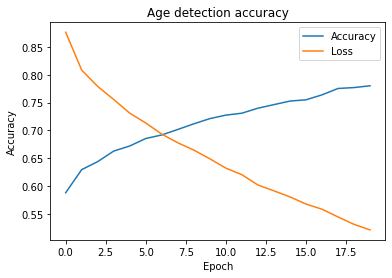

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Age detection accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'])
plt.show()

#### Test model

In [ ]:
image_test = X_test[0].reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
prediction = model.predict([image_test])
print(f'Test: {y_test[0]} Model: {prediction}')

In [ ]:
prediction = model.predict(image_test)
prediction

In [ ]:
plt.imshow(image_test.reshape(28,28))

### 4.2 Second Model

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=X_data.shape[1:], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5), # Disable some neurons to improve the CNN
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])


In [170]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )

#### Manual

In [104]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [108]:
history_2 = model.fit(
    X_train, 
    y_train, 
    batch_size=32,
    validation_data=(X_test, y_test), 
    epochs=10,
    validation_split=0.3
)

Epoch 1/10
180/180 [==============================] - 22s 122ms/step - loss: 0.7967 - accuracy: 0.6490 - val_loss: 0.8262 - val_accuracy: 0.6238
Epoch 2/10
180/180 [==============================] - 23s 128ms/step - loss: 0.7750 - accuracy: 0.6600 - val_loss: 0.8395 - val_accuracy: 0.6231
Epoch 3/10
180/180 [==============================] - 27s 147ms/step - loss: 0.7526 - accuracy: 0.6663 - val_loss: 0.8113 - val_accuracy: 0.6377
Epoch 4/10
180/180 [==============================] - 27s 147ms/step - loss: 0.7297 - accuracy: 0.6784 - val_loss: 0.8330 - val_accuracy: 0.6356
Epoch 5/10
180/180 [==============================] - 27s 148ms/step - loss: 0.7152 - accuracy: 0.6929 - val_loss: 0.8090 - val_accuracy: 0.6426
Epoch 6/10
180/180 [==============================] - 27s 149ms/step - loss: 0.6914 - accuracy: 0.7005 - val_loss: 0.7973 - val_accuracy: 0.6558
Epoch 7/10
180/180 [==============================] - 26s 146ms/step - loss: 0.6642 - accuracy: 0.7193 - val_loss: 0.7620 - val_ac

In [109]:
model.save('./age_detection_data/model2.model')

INFO:tensorflow:Assets written to: ./age_detection_data/model2.model/assets


INFO:tensorflow:Assets written to: ./age_detection_data/model2.model/assets


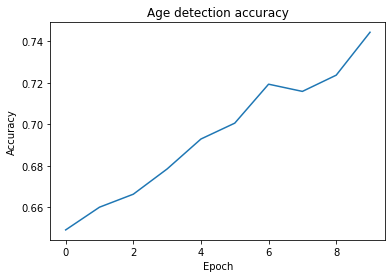

In [110]:
plt.plot(history_2.history['accuracy'])
plt.title('Age detection accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Using general functions

Epoch 1/25
180/180 [==============================] - 28s 147ms/step - loss: 1.0476 - accuracy: 0.4350 - val_loss: 0.9708 - val_accuracy: 0.5459
Epoch 2/25
180/180 [==============================] - 24s 134ms/step - loss: 0.9331 - accuracy: 0.5743 - val_loss: 0.9168 - val_accuracy: 0.5807
Epoch 3/25
180/180 [==============================] - 24s 131ms/step - loss: 0.8841 - accuracy: 0.5990 - val_loss: 0.8943 - val_accuracy: 0.5821
Epoch 4/25
180/180 [==============================] - 23s 129ms/step - loss: 0.8400 - accuracy: 0.6277 - val_loss: 0.8555 - val_accuracy: 0.6036
Epoch 5/25
180/180 [==============================] - 27s 150ms/step - loss: 0.8058 - accuracy: 0.6414 - val_loss: 0.8387 - val_accuracy: 0.6175
Epoch 6/25
180/180 [==============================] - 24s 134ms/step - loss: 0.7873 - accuracy: 0.6543 - val_loss: 0.8210 - val_accuracy: 0.6370
Epoch 7/25
180/180 [==============================] - 24s 131ms/step - loss: 0.7472 - accuracy: 0.6730 - val_loss: 0.7924 - val_ac

INFO:tensorflow:Assets written to: ./age_detection_data/model3.model/assets


INFO:tensorflow:Assets written to: ./age_detection_data/model3.model/assets


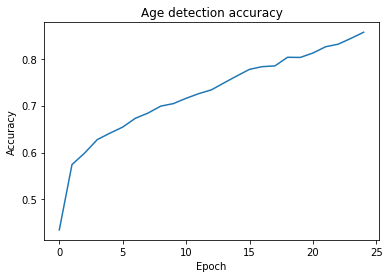

In [171]:
hystory, model_fit = run_model(model, 'model3.model')

##### Test model

45/45 [==============================] - 2s 44ms/step


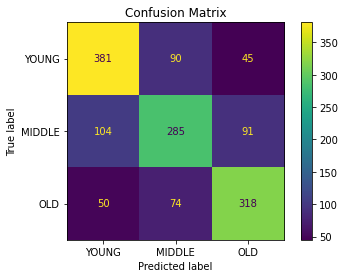

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       516
           1       0.63      0.59      0.61       480
           2       0.70      0.72      0.71       442

    accuracy                           0.68      1438
   macro avg       0.68      0.68      0.68      1438
weighted avg       0.68      0.68      0.68      1438



In [172]:
test_model(model_fit, X_test, y_test)